In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skmultilearn.adapt import MLkNN
from skmultilearn.model_selection import IterativeStratification
from skmultilearn.dataset import available_data_sets
from skmultilearn.dataset import load_dataset

import time

import warnings
warnings.filterwarnings('ignore')

#  Particle.py

In [2]:
class Particle:
    
    def __init__(self, length, pos_max, pos_min, vel_max, vel_min, w, c1, c2, problem):
        self.length = length
        self.pos_max = pos_max
        self.pos_min = pos_min
        self.vel_max = vel_max
        self.vel_min = vel_min
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.problem = problem

        self.position = np.random.rand(length)*(pos_max-pos_min)
        self.velocity = np.zeros(length)
        self.fitness = self.problem.worst_fitness()

        self.pbest_pos = np.zeros(length)
        self.pbest_fit = self.problem.worst_fitness()

        self.gbest_pos = np.zeros(length)
        self.gbest_fit = self.problem.worst_fitness()

    def update(self):
        # Update velocity
        self.velocity = self.w * self.velocity + \
            self.c1 * np.random.rand(self.length) * (self.pbest_pos - self.position) + \
            self.c2 * np.random.rand(self.length) * \
            (self.gbest_pos - self.position)

        self.velocity[self.velocity < self.vel_min] = self.vel_min
        self.velocity[self.velocity > self.vel_max] = self.vel_max

        # update position
        self.position = self.position + self.velocity
        self.position[self.position < self.pos_min] = self.pos_min
        self.position[self.position > self.pos_max] = self.pos_max

In [3]:
class Swarm:

    def __init__(self, n_particles, length, pos_max, pos_min, vel_max, vel_min, problem, n_iterations):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.problem = problem

        w = 0.8
        c1 = 1.46
        c2 = 1.46
        self.population = [Particle(length = length, 
                                    pos_max = pos_max, pos_min = pos_min, 
                                    vel_max = vel_max, vel_min = vel_min, 
                                    w = w, c1 = c1, c2 = c2, problem = problem)
                           for _ in range(n_particles)]

    def iterate(self):

        for i in range(self.n_iterations):
            
            print('Iterate ', i, end = '  ')
            gbest_fit = self.population[0].gbest_fit
            gbest_index = 0
            gbest_updated = False
            print('gbest value is ', gbest_fit)
            
            for index, particle in enumerate(self.population):
                # Evaluate each particle, update pbest
                particle.fitness = self.problem.fitness(particle.position)

                if self.problem.is_better(particle.fitness, particle.pbest_fit):
                    particle.pbest_fit = particle.fitness
                    particle.pbest_pos = np.copy(particle.position)

                if self.problem.is_better(particle.pbest_fit, gbest_fit):
                    gbest_fit = particle.pbest_fit
                    gbest_index = index
                    gbest_updated = True

            if gbest_updated:
                for particle in self.population:
                    particle.gbest_fit = self.population[gbest_index].pbest_fit
                    particle.gbest_pos = np.copy(
                        self.population[gbest_index].pbest_pos)

            # now update particle position:
            for particle in self.population:
                particle.update()

        return self.population[0].gbest_pos, self.population[0].gbest_fit

#  Problem.py

In [4]:
class Problem:
    def __init__(self, minimize):
        self.minimize = minimize

    def fitness(self, solution):
        return 1
    
    def is_better(self, first, second):
        if self.minimize:
            return first < second
        else:
            return first > second

    def worst_fitness(self):
        if self.minimize:
            return float('inf')
        else:
            return float('-inf')

In [5]:
class FS(Problem):

    def __init__(self, minimize, X, y):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        if len(feature_selected) == 0:
            return self.worst_fitness()
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        clf = KNN()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        return acc

In [6]:
# Standard PSO
# Fitness is MLKNN classification hamming loss.

class FS_ML(Problem):
    
    def __init__(self, minimize, X, y):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        if len(feature_selected) == 0:
            return self.worst_fitness()
        
        n_splits = 5
        clf = MLkNN(k=3)
        scaler = StandardScaler()
#         scaler = MinMaxScaler()
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)

        hamming_losses = 0
        for train_idx, test_idx in k_fold.split(X, y):
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            ham = hamming_loss(y_test, y_pred)
            hamming_losses += ham
        
        return hamming_losses/n_splits    

In [8]:
# Super label PSO
# Fitness is use super+sub classification hamming loss

class FS_ML_super(Problem):
    
    def __init__(self, minimize, X, y):
        self.minimize = minimize,
        self.X = X
        self.y = y
        self.threshold = 0.6

    def fitness(self, solution):
        feature_selected = np.where(solution > self.threshold)[0]
        X = self.X[:, feature_selected]
        y = self.y
        if len(feature_selected) == 0:
            return self.worst_fitness()
        
        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)
            
        hamming_losses = 0
        for train_idx, test_idx in k_fold.split(X, y):
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
            y_test_pred, y_test = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df)
            
        
            ham = hamming_loss(y_test, y_test_pred)
            hamming_losses += ham
        
        return hamming_losses/n_splits

# Super_labels.py

In [9]:
# In each subcgroup(cluster), get label indexes 

def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [10]:
# Convert each subgroup's labels(binary nparray) into super label(list)
# If all labels are 0, super label is 0; otherwise, super label is assigned to 1

def convert(subgroup_label):
    super_ = []
    subgroup_label_array = subgroup_label.to_numpy()
    rows = subgroup_label.shape[0]
    columns = subgroup_label.shape[1]
    for row in range(rows):
        s = 0
        for column in range(columns):
            if subgroup_label_array[row][column] == 1:
                s = 1
                break
        super_.append(s)
    return super_

In [11]:
# Convert original y labels into y_super labels
# subgroup_labels are dataframe with original labels + super labels

def label_convert(y_train_, no_cls):  # Here y is dataframe
    
    subgroups = []
    super_labels = []
    kmeans = KMeans(n_clusters=no_cls, random_state=0).fit(y_train_.T)
    dict_clst_col = dict()  # dictionary to record key(cluster index) and value(cluster columns)
    
    for i in range(no_cls):
        cluster = ClusterIndicesNumpy(i, kmeans.labels_)  # Column numbers(indexes) of all the labels in each cluster
        dict_clst_col[i] = cluster
        subgroup_label = y_train_.iloc[:,cluster]   # Get all the original labels from cluster, dataframe form
        s = pd.DataFrame(convert(subgroup_label), columns = ['s'+ str(i)])   # Convert original labels to a column super label
        super_labels.append(s)
        subgroup_label['s' + str(i)] = s   # Concat s into subgroup
        subgroups.append(subgroup_label)        
        
    y_s = pd.concat(super_labels, axis=1)   # Combine all super label columns, as orginal y converted to super_label y, the target
    y_s = y_s.to_numpy()

    return y_s, subgroups, dict_clst_col

In [12]:
# After split, indexes of X_train, X_test and y_train, y_test will be discorder, aka not ascending any more.
# If index disorder, will be tricky to process index, e.g. zero_idx
# Need to reorder index first.

def convert_index(X_train, X_test, y_train, y_test):
    
    X_train_ = X_train.reset_index(drop=True)
    y_train_ = y_train.reset_index(drop=True)
    X_test_ = X_test.reset_index(drop=True)
    y_test_ = y_test.reset_index(drop=True)
    
    return X_train_, X_test_, y_train_, y_test_

When doing super and sub classification on training set, k-fold is not neccesary. 
Only the classifiers are required.

In [13]:
# Get trained super_classifier

def super_classifier(X_train_, y_train_, no_cls):
    
    clf = MLkNN(k=3)

    scaler_1 = StandardScaler()
    scaler_2 = MinMaxScaler()
    X_train_scaled_1 = scaler_1.fit_transform(X_train_)
    X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
#     scaler = StandardScaler()
#     X_train_ = scaler.fit_transform(X_train_)
#     X_train_ = MinMaxScaler().fit_transform(X_train_)
    y_s, subgroups, dict_clst_col = label_convert(y_train_, no_cls)
    clf.fit(X_train_scaled_2, y_s)
#     clf.fit(X_train_, y_s)
    
    return clf

In [14]:
# For each subgroup, collect all the zero super labels
# The len of total_zeros is the number of subgroups, also the number of super labels

def zeros(y_s):

    total_zeros = []
    for i in range(y_s.shape[1]):     # number of super labels
        idx_zeros = []
        for j in range(y_s.shape[0]):   # number of instances
            if y_s[j][i] == 0:
                idx_zeros.append(j)
        total_zeros.append(idx_zeros)
        
    return total_zeros

In [15]:
# In each subgroup, if a particular row of y_s is zero, the corresponding X features also needs to be removed.
# For each subgroup, get the indexes of zeros in one y_s, and remove these same indexes from X feature instances.
# Each subgroup contains its own X, means different subgroup contain diffenrent number of instances
# Collect each removed X and return.

def remove_zeros(X, y_s):  # y_s is ndarray
    total_zeros = zeros(y_s)
    Xs = []
    for idx_zeros in total_zeros:
        X_ = pd.DataFrame(X).drop(idx_zeros)   
        Xs.append(X_)  
    return Xs

From original X and y, compute super label y(y_s), which actually comes from true y.
Each subgroup contains original y labels + y_s label.
Check each y_s, if 0, than remove the whole line, which means remove its corresponding original labels, and its X.
So the remaining of original labels, as well as X of each subgroup are different, since indexes of zeros in each y super label are different.

def sub_classification is for each subgroup, train X_(X remove y_s's zero indexes) and y_(y sub original labels remove y_s's zero indexes).
After training, collect all sub-clfs and Xs.

In [16]:
# Get trained sub classifiers

def sub_classifiers(X_train_, y_train_, no_cls):
    
    clfs = []
    n_sub_labelses = []
    y_s, subgroups, dict_clst_col = label_convert(y_train_, no_cls)   # y_super labels, converted from original y labels (target)
    total_zeros = zeros(y_s)
#     scaler = StandardScaler() 
#     scaler = MinMaxScaler()
    scaler_1 = StandardScaler() 
    scaler_2 = MinMaxScaler()
    Xs = remove_zeros(X_train_, y_s)
    
    for subgroup, idx_zeros, X in zip(subgroups,total_zeros, Xs):
                                                 # Have different X, because idx of zero are different
        y_ = subgroup.drop(idx_zeros)            # Drop all the zero instances, both in X and y, aka X_, y_ 
        y_ = y_.drop(y_.columns[-1:], axis = 1)  # Remove the s label
        n_sub_labels = subgroup.shape[1]-1
        n_sub_labelses.append(n_sub_labels)
        
        X_scaled_1 = scaler_1.fit_transform(X)
        X_scaled_2 = scaler_2.fit_transform(X_scaled_1)
#         X_ = scaler.fit_transform(X)
        clf = MLkNN(k=3)
#         clf.fit(X_, y_.to_numpy())
        clf.fit(X_scaled_2, y_.to_numpy())
        
        clfs.append(clf)

    return clfs, n_sub_labelses

Now already gained clf, which is classifier for super classification, and clfs which are for all the sub-classifications.
Then will apply clf and clfs on training set, to see the training_loss, and then apply on test set, to get test_loss.
Finally, compare.

1. Apply clf, clfs, Xs on training set.

In [17]:
# Do super classification on dataset

def super_classification(clf_super, X_test_):
#     scaler = StandardScaler()
    scaler_1 = StandardScaler()
    scaler_2 = MinMaxScaler()
    X_test_scaled_1 = scaler_1.fit_transform(X_test_)
    X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)
#     X_test_scaled = scaler.fit_transform(X_test_)
#     X_test_scaled = MinMaxScaler().fit_transform(X_test_)
#     y_test_s_pred = clf_super.predict(X_test_scaled).toarray()   # Predicted super labels, will be passed into def zeros().
    y_test_s_pred = clf_super.predict(X_test_scaled_2).toarray()
    return y_test_s_pred

In [18]:
# Do sub-classification on sub-datasets (original X + subgroup original labels)

def sub_classification(clfs, n_sub_labelses, X_test_, y_test_s_pred):

    total_test_zeros = zeros(y_test_s_pred)    # Based on predicted super label, compute which are zeros in each subgroup
    
    X_tests = remove_zeros(X_test_, y_test_s_pred)  # Remove zeros in each subgroup in X
    
    y_test_sub_preds = []
#     scaler = StandardScaler() 
#     scaler = MinMaxScaler()
    scaler_1 = StandardScaler() 
    scaler_2 = MinMaxScaler()
    for clf, X_test in zip(clfs, X_tests):
        if len(X_test.axes[0]) == 0:  # based on corrrespanding y_s_pred column, the y_labels in column are all zeros
            y_test_sub_pred = None  # so when remove zeros in X_test, n_rowsof X-test is 0, aka no intances to predict
            y_test_sub_preds.append(y_test_sub_pred)
        else:
#             X_scaled = scaler.fit_transform(X_test)
            X_scaled_1 = scaler_1.fit_transform(X_test)
            X_scaled_2 = scaler_2.fit_transform(X_scaled_1)
#             y_test_sub_pred = clf.predict(X_scaled)   # y_test_sub_pred is sparse matrix
            y_test_sub_pred = clf.predict(X_scaled_2)
            y_test_sub_preds.append(y_test_sub_pred)
        
    return total_test_zeros, y_test_sub_preds    # total_test_zeros, y_test_sub_labels are lists

After super and sub-classifications are done on test/validation dataset, the next step is to revert and rebuild all the predicted sub-labels together. 
The predicted subgroups do not contain all the original instances, coz those all-zeros instances are removed before sub-classification. So when doing revert, we need to find out which instances are all-zeros(those predicted super-predicted are zero), these can be reverted to [0,0,0,...].
If the super-predicted label is not 0, then this predicted instance's subgroup labels are in coreesponding y_sub_pred. 

len(total_zeros) is number of subgroups, aka number of columns for super_y_labels
for each subgroup, y.shape[0] is the rows, aka instances in original y, 
if index of the instance is included in column in total_zeros, that means when revert to original labels, we can impute all the subgroup labels of this instance to all zeros

How to impute the zero super label's corresponding sub-labels to zeros? We need to know how many sub-labels in each cluster. That is how many labels in each y_sub_pred

In [19]:
# Fill out zeros back into each y_sub_pred

def fill_zeros(total_test_zeros, y_test_sub_preds, y_test_, n_sub_labelses):
    total_filled_preds = []
    
    for i in range(len(total_test_zeros)):   # number of columns of y_super
        labels = []     
        if y_test_sub_preds[i] == None:
            for j in range(y_test_.shape[0]):   
                labels.append(np.zeros(n_sub_labelses[i], dtype=np.int64))   # Create all zero list, then list of list, append
        else:
            y_test_sub_pred_np = y_test_sub_preds[i].toarray()     # y_test_sub_pred is sparse matrix, convert to nparray
            no_sublabels = y_test_sub_pred_np.shape[1]
            for j in range(y_test_.shape[0]):   # original y_test's rows
                if j in total_test_zeros[i]:   
                    labels.append(np.zeros(no_sublabels, dtype=np.int64))                                          
                else:
                    label = y_test_sub_pred_np[0]             
                    labels.append(label)
                    y_test_sub_pred_np = np.delete(y_test_sub_pred_np, [0], axis = 0)
        total_filled_preds.append(labels)  
        
    return total_filled_preds

In [20]:
# sort the order of y_test_preds, aka revert to original order as y_test's columns(before clustering)
# Clusters are not neccessarily equal, so could convert total_filled_preds to np.array

def sort_preds(total_filled_preds, y_train_, no_cls):
    
    y_s, subgroup, dict_clst_col = label_convert(y_train_, no_cls)
    y_test_sub_preds = []
    for i in range(len(total_filled_preds)):
        np_total_filled_pred = np.array(total_filled_preds[i])
        y_test_sub_preds.append(pd.DataFrame(np_total_filled_pred, columns = dict_clst_col[i]))
    y_test_pred = pd.concat(y_test_sub_preds, axis = 1)
    y_test_pred_t = y_test_pred.T
    y_test_pred_t_sorted = y_test_pred_t.sort_index(ascending=True)
    y_test_pred_sorted = y_test_pred_t_sorted.T

    return y_test_pred_sorted

In [21]:
# Based on splited X_train, y_train, calculate the y_test_pred on x_test

def calc_preds(X_train, y_train, X_test, y_test, no_cls):
    
    X_train_, X_test_, y_train_, y_test_ = convert_index(X_train, X_test, y_train, y_test)
    
    clf_super = super_classifier(X_train_, y_train_, no_cls)
    clfs_sub, n_sub_labelses = sub_classifiers(X_train_, y_train_, no_cls)
    y_test_s_pred = super_classification(clf_super, X_test_)
    total_test_zeros, y_test_sub_preds = sub_classification(clfs_sub, n_sub_labelses, X_test_, y_test_s_pred)
    total_filled_preds = fill_zeros(total_test_zeros, y_test_sub_preds, y_test_, n_sub_labelses)
    y_test_pred_sorted = sort_preds(total_filled_preds, y_train_, no_cls)
    
    return y_test_pred_sorted, y_test_

#  Util.py

In [22]:
# K-fold only accept X, y in numpy form, and return X_train, X_test, y_train, y_test in each loop(split).
# Convert X_train, X_test, y_train, y_test from numpy to dataframe, for super_label calculation call.

def Convert_to_df(X_train, X_test, y_train, y_test):
    
    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    y_train_df = pd.DataFrame(y_train)
    y_test_df = pd.DataFrame(y_test)
    
    return X_train_df, X_test_df, y_train_df, y_test_df

In [23]:
# Read arff file.

def read_arff(file):
    with open(file, encoding="utf-8") as f:
        header = []
        for line in f:
            if line.startswith("@attribute"):
                header.append(line.split()[1])
            elif line.startswith("@data"):
                break
        df = pd.read_csv(f, header=None)
        df.columns = header
    return df

# Main.py

In [24]:
set([x[0] for x in available_data_sets().keys()])

{'Corel5k',
 'bibtex',
 'birds',
 'delicious',
 'emotions',
 'enron',
 'genbase',
 'mediamill',
 'medical',
 'rcv1subset1',
 'rcv1subset2',
 'rcv1subset3',
 'rcv1subset4',
 'rcv1subset5',
 'scene',
 'tmc2007_500',
 'yeast'}

In [25]:
datasets = ['CAL500', 'flags']
n_featureses = [68, 19]
n_labels = [174, 7]

In [26]:
datasets_small = ['emotions', 'scene']
datasets_medium = ['yeast', 'birds', 'genbase']
datasets_large = ['medical', 'enron', 'bibtex', 'Corel5k']
datasets_list = [datasets_small, datasets_medium, datasets_large]
# datasets_list = [datasets_medium]

no_clses_small = [2, 4]
no_clses_medium = [2, 4, 6, 8]
no_clses_large = [2, 4, 6, 8, 10]
no_clses_list = [no_clses_small, no_clses_medium, no_clses_large]
# no_clses_list = [no_clses_medium]

Standard classification with full features vs Super classification with full features. 

In [27]:
# Main entry

# for dataset, n_features in zip(datasets, n_featureses):
    
#     data = read_arff('datasets/' + dataset + '.arff')

#     y = data.iloc[:10000, n_features:]
#     X = data.iloc[:10000, :n_features]

# #     n_features = len(list(X))
#     X = X.to_numpy()
#     y = y.to_numpy()

for datasets, no_clses in zip(datasets_list, no_clses_list):
    for i in range(len(datasets)):
        X, y, feature_names, label_names = load_dataset(datasets[i], 'undivided')
        X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
        y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

        n_splits = 5
        k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state=42)

        standard_hams = []
        super_hams = []
        to_print = ''
        fold_count = 0

        for train_idx, test_idx in k_fold.split(X, y):
            
            fold_count += 1
            print('Split ============================================================================', fold_count)
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]


            # get super classification acc(hl)
            dict_cls_ham = dict()   # no_cls:super_ham dictionary
            for no_cls in no_clses:   
                print('no_cls is ', no_cls)
                X_train_df, X_test_df, y_train_df, y_test_df = Convert_to_df(X_train, X_test, y_train, y_test)            
                y_test_pred_super, y_test_super = calc_preds(X_train_df, y_train_df, X_test_df, y_test_df, no_cls)
                super_ham = hamming_loss(y_test_super, y_test_pred_super)        
                dict_cls_ham[no_cls] = super_ham
                print('super_ham: ', super_ham)
                print('dict_cls_ham: ', dict_cls_ham)
            super_hams.append(dict_cls_ham)
            print('super_hams: ', super_hams)
            print("-------------------------------------------------------------")


            # get standard classficaition acc(hl)
            scaler_1 = StandardScaler()
            scaler_2 = MinMaxScaler()
            X_train_scaled_1 = scaler_1.fit_transform(X_train)
            X_test_scaled_1 = scaler_1.fit_transform(X_test)
            X_train_scaled_2 = scaler_2.fit_transform(X_train_scaled_1)
            X_test_scaled_2 = scaler_2.fit_transform(X_test_scaled_1)

            clf = MLkNN(k=3)
            clf.fit(X_train_scaled_2, y_train)
            y_test_pred = clf.predict(X_test_scaled_2)
            standard_ham = hamming_loss(y_test, y_test_pred)
            print('standard_ham: ', standard_ham)
            standard_hams.append(standard_ham)

            # to write the results
            to_print += '--------------Fold %d----------------\n' % fold_count
            to_print += 'Standard classification with full feature hamming loss: %.4f\n' % standard_ham
            if len(no_clses) == 2:
                to_print += 'Super classification with full feature hamming loss with 2 clusters: %.4f\n' % dict_cls_ham[2]
                to_print += 'Super classification with full feature hamming loss with 4 clusters: %.4f\n' % dict_cls_ham[4]
            elif len(no_clses) == 4:
                to_print += 'Super classification with full feature hamming loss with 2 clusters: %.4f\n' % dict_cls_ham[2]
                to_print += 'Super classification with full feature hamming loss with 4 clusters: %.4f\n' % dict_cls_ham[4]
                to_print += 'Super classification with full feature hamming loss with 6 clusters: %.4f\n' % dict_cls_ham[6]
                to_print += 'Super classification with full feature hamming loss with 8 clusters: %.4f\n' % dict_cls_ham[8]
            else:
                to_print += 'Super classification with full feature hamming loss with 2 clusters: %.4f\n' % dict_cls_ham[2]
                to_print += 'Super classification with full feature hamming loss with 4 clusters: %.4f\n' % dict_cls_ham[4]
                to_print += 'Super classification with full feature hamming loss with 6 clusters: %.4f\n' % dict_cls_ham[6]
                to_print += 'Super classification with full feature hamming loss with 8 clusters: %.4f\n' % dict_cls_ham[8]
                to_print += 'Super classification with full feature hamming loss with 10 clusters: %.4f\n' % dict_cls_ham[10]

        to_print += '--------------Average----------------\n'
        to_print += 'Ave Standard Classification Accuracy: %.4f\n' % np.average(standard_hams)
        # to_print += 'Ave Super Classification Accuracy: %.4f\n' % np.average(super_hams)
        if len(no_clses) == 2:
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % np.average([super_hams[0][2], super_hams[1][2], super_hams[2][2], super_hams[3][2], super_hams[4][2]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % np.average([super_hams[0][4], super_hams[1][4], super_hams[2][4], super_hams[3][4], super_hams[4][4]])
        elif len(no_clses) == 4:
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % np.average([super_hams[0][2], super_hams[1][2], super_hams[2][2], super_hams[3][2], super_hams[4][2]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % np.average([super_hams[0][4], super_hams[1][4], super_hams[2][4], super_hams[3][4], super_hams[4][4]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % np.average([super_hams[0][6], super_hams[1][6], super_hams[2][6], super_hams[3][6], super_hams[4][6]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % np.average([super_hams[0][8], super_hams[1][8], super_hams[2][8], super_hams[3][8], super_hams[4][8]])
        else:
            to_print += 'Ave Super Classification with 2 clusters: %.4f\n' % np.average([super_hams[0][2], super_hams[1][2], super_hams[2][2], super_hams[3][2], super_hams[4][2]])
            to_print += 'Ave Super Classification with 4 clusters: %.4f\n' % np.average([super_hams[0][4], super_hams[1][4], super_hams[2][4], super_hams[3][4], super_hams[4][4]])
            to_print += 'Ave Super Classification with 6 clusters: %.4f\n' % np.average([super_hams[0][6], super_hams[1][6], super_hams[2][6], super_hams[3][6], super_hams[4][6]])
            to_print += 'Ave Super Classification with 8 clusters: %.4f\n' % np.average([super_hams[0][8], super_hams[1][8], super_hams[2][8], super_hams[3][8], super_hams[4][8]])
            to_print += 'Ave Super Classification with 10 clusters: %.4f\n' % np.average([super_hams[0][10], super_hams[1][10], super_hams[2][10], super_hams[3][10], super_hams[4][10]])

        f = open('records/record_std_minmaxscaler_' + datasets[i] + '_full_standard_super_clf.txt', 'w')
        f.write(to_print)
        f.close()

emotions:undivided - exists, not redownloading
Split ============================================================================ 1
no_cls is  2
super_ham:  0.21577380952380953
dict_cls_ham:  {2: 0.21577380952380953}
no_cls is  4
super_ham:  0.21875
dict_cls_ham:  {2: 0.21577380952380953, 4: 0.21875}
super_hams:  [{2: 0.21577380952380953, 4: 0.21875}]
-------------------------------------------------------------
standard_ham:  0.21279761904761904
Split ============================================================================ 2
no_cls is  2
super_ham:  0.23415977961432508
dict_cls_ham:  {2: 0.23415977961432508}
no_cls is  4
super_ham:  0.26170798898071623
dict_cls_ham:  {2: 0.23415977961432508, 4: 0.26170798898071623}
super_hams:  [{2: 0.21577380952380953, 4: 0.21875}, {2: 0.23415977961432508, 4: 0.26170798898071623}]
-------------------------------------------------------------
standard_ham:  0.24793388429752067
Split =================================================================

super_ham:  0.23651452282157676
dict_cls_ham:  {2: 0.23117960877296978, 4: 0.24273858921161826, 6: 0.23651452282157676}
no_cls is  8
super_ham:  0.235773562537048
dict_cls_ham:  {2: 0.23117960877296978, 4: 0.24273858921161826, 6: 0.23651452282157676, 8: 0.235773562537048}
super_hams:  [{2: 0.227918205055382, 4: 0.2327463788696393, 6: 0.22806021016756603, 8: 0.2250781028117012}, {2: 0.22434402332361517, 4: 0.23294460641399417, 6: 0.22784256559766763, 8: 0.22463556851311953}, {2: 0.22006520450503853, 4: 0.22777119146413752, 6: 0.22599288678126853, 8: 0.22495554238292828}, {2: 0.23117960877296978, 4: 0.24273858921161826, 6: 0.23651452282157676, 8: 0.235773562537048}]
-------------------------------------------------------------
standard_ham:  0.23073503260225253
Split ============================================================================ 5
no_cls is  2
super_ham:  0.21381987577639752
dict_cls_ham:  {2: 0.21381987577639752}
no_cls is  4
super_ham:  0.22826086956521738
dict_cls_ham:  

standard_ham:  0.03150912106135987
Split ============================================================================ 3
no_cls is  2
super_ham:  0.04405162738496072
dict_cls_ham:  {2: 0.04405162738496072}
no_cls is  4
super_ham:  0.058922558922558925
dict_cls_ham:  {2: 0.04405162738496072, 4: 0.058922558922558925}
no_cls is  6
super_ham:  0.043209876543209874
dict_cls_ham:  {2: 0.04405162738496072, 4: 0.058922558922558925, 6: 0.043209876543209874}
no_cls is  8
super_ham:  0.0457351290684624
dict_cls_ham:  {2: 0.04405162738496072, 4: 0.058922558922558925, 6: 0.043209876543209874, 8: 0.0457351290684624}
super_hams:  [{2: 0.03166525303929884, 4: 0.033927056827820185, 6: 0.03307888040712468, 8: 0.03618886061634153}, {2: 0.0406301824212272, 4: 0.040353786622443336, 6: 0.04532891100055279, 8: 0.048645660585959094}, {2: 0.04405162738496072, 4: 0.058922558922558925, 6: 0.043209876543209874, 8: 0.0457351290684624}]
-------------------------------------------------------------
standard_ham:  0.0

super_ham:  0.017733990147783252
dict_cls_ham:  {2: 0.017733990147783252}
no_cls is  4
super_ham:  0.01718664477285167
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167}
no_cls is  6
super_ham:  0.01784345922276957
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167, 6: 0.01784345922276957}
no_cls is  8
super_ham:  0.020361247947454843
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167, 6: 0.01784345922276957, 8: 0.020361247947454843}
no_cls is  10
super_ham:  0.01784345922276957
dict_cls_ham:  {2: 0.017733990147783252, 4: 0.01718664477285167, 6: 0.01784345922276957, 8: 0.020361247947454843, 10: 0.01784345922276957}
super_hams:  [{2: 0.01706758304696449, 4: 0.015807560137457044, 6: 0.015693012600229095, 8: 0.015693012600229095, 10: 0.016151202749140895}, {2: 0.01761229314420804, 4: 0.01619385342789598, 6: 0.016430260047281323, 8: 0.01773049645390071, 10: 0.015484633569739953}, {2: 0.018171866447728516, 4: 0.017077175697865352, 6: 0.016310892172961

super_ham:  0.01683924926569423
dict_cls_ham:  {2: 0.016893181327890344, 4: 0.01688488408755248, 6: 0.01743250194985148, 8: 0.017324637825459253, 10: 0.01683924926569423}
super_hams:  [{2: 0.016893181327890344, 4: 0.01688488408755248, 6: 0.01743250194985148, 8: 0.017324637825459253, 10: 0.01683924926569423}]
-------------------------------------------------------------
standard_ham:  0.01690147856822821
Split ============================================================================ 2
no_cls is  2
super_ham:  0.016960651289009497
dict_cls_ham:  {2: 0.016960651289009497}
no_cls is  4
super_ham:  0.016913716153366957
dict_cls_ham:  {2: 0.016960651289009497, 4: 0.016913716153366957}
no_cls is  6
super_ham:  0.016926516644905833
dict_cls_ham:  {2: 0.016960651289009497, 4: 0.016913716153366957, 6: 0.016926516644905833}
no_cls is  8
super_ham:  0.017173992814657417
dict_cls_ham:  {2: 0.016960651289009497, 4: 0.016913716153366957, 6: 0.016926516644905833, 8: 0.017173992814657417}
no_cls is 

super_ham:  0.01240566994353539
dict_cls_ham:  {2: 0.012306936928282473, 4: 0.01224022543148996, 6: 0.012168177014954049, 8: 0.01240566994353539}
no_cls is  10
super_ham:  0.012483055279814703
dict_cls_ham:  {2: 0.012306936928282473, 4: 0.01224022543148996, 6: 0.012168177014954049, 8: 0.01240566994353539, 10: 0.012483055279814703}
super_hams:  [{2: 0.012307089101146846, 4: 0.012462289118572813, 6: 0.012622934750645305, 8: 0.012843482143829575, 10: 0.012631103172615094}, {2: 0.012387798388845692, 4: 0.01245920542481897, 6: 0.012266141957187515, 8: 0.01217093257588981, 10: 0.012160353755745621}, {2: 0.012306936928282473, 4: 0.01224022543148996, 6: 0.012168177014954049, 8: 0.01240566994353539, 10: 0.012483055279814703}]
-------------------------------------------------------------
standard_ham:  0.011861304129708497
Split ============================================================================ 4
no_cls is  2
super_ham:  0.011785293853698708
dict_cls_ham:  {2: 0.011785293853698708}
no_

In [93]:
from matplotlib import pyplot as plt

Ave Standard Classification Accuracy: 0.2153
Ave Super Classification with 2 clusters: 0.2181
Ave Super Classification with 4 clusters: 0.2111

In [114]:
# from matplotlib import pyplot as plt
# plt.xlabel('Number of clusters') 
# plt.ylabel('Accuracy (Hamming_loss)') 
# plt.axhline(y=0.2153, color='r', linestyle='-')
# x_values = [2, 4]
# y_values = [0.2181, 0.2111]
# plt.plot(x_values, y_values) 
# plt.title('emotions')
# plt.show()

rd Classification Accuracy: 0.0923
Ave Super Classification with 2 clusters: 0.0923
Ave Super Classification with 4 clusters: 0.0951

In [112]:
# plt.xlabel('Number of clusters') 
# plt.ylabel('Accuracy (Hamming_loss)') 
# plt.axhline(y=0.0923, color='r', linestyle='-')
# x_values = [2, 4]
# y_values = [0.0923, 0.0951]
# plt.plot(x_values, y_values) 
# plt.title('scene')
# plt.show()

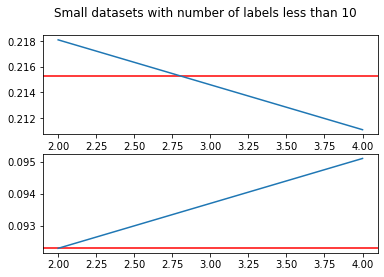

In [115]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Small datasets with number of labels less than 10')
x = [2, 4]
y_emotions = [0.2181, 0.2111]
y_scene = [0.0923, 0.0951]
ax1.axhline(y=0.2153, color='r', linestyle='-')
ax1.plot(x, y_emotions)
ax2.axhline(y=0.0923, color='r', linestyle='-')
ax2.plot(x, y_scene)

yeast 
Ave Standard Classification Accuracy: 0.2172
Ave Super Classification with 2 clusters: 0.2216
Ave Super Classification with 4 clusters: 0.2281
Ave Super Classification with 6 clusters: 0.2248
Ave Super Classification with 8 clusters: 0.2226

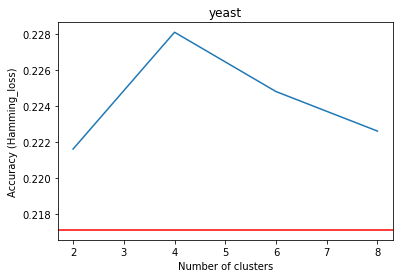

In [100]:
plt.xlabel('Number of clusters') 
plt.ylabel('Accuracy (Hamming_loss)') 
plt.axhline(y=0.2171, color='r', linestyle='-')
x_values = [2, 4, 6, 8]
y_values = [0.2216, 0.2281, 0.2248, 0.2226]
plt.plot(x_values, y_values) 
plt.title('yeast')
plt.show()

birds
Ave Standard Classification Accuracy: 0.0478
Ave Super Classification with 2 clusters: 0.0493
Ave Super Classification with 4 clusters: 0.0486
Ave Super Classification with 6 clusters: 0.0477
Ave Super Classification with 8 clusters: 0.0503

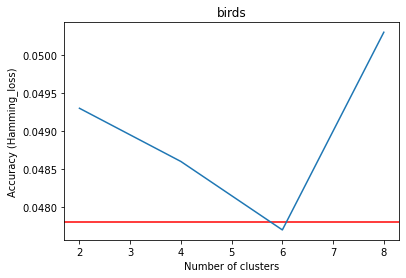

In [103]:
plt.xlabel('Number of clusters') 
plt.ylabel('Accuracy (Hamming_loss)') 
plt.axhline(y=0.0478, color='r', linestyle='-')
x_values = [2, 4, 6, 8]
y_values = [0.0493, 0.0486, 0.0477, 0.0503]
plt.plot(x_values, y_values) 
plt.title('birds')
plt.show()

genbase
Ave Standard Classification Accuracy: 0.0039
Ave Super Classification with 2 clusters: 0.0040
Ave Super Classification with 4 clusters: 0.0041
Ave Super Classification with 6 clusters: 0.0041
Ave Super Classification with 8 clusters: 0.0041

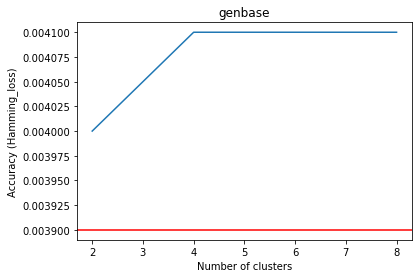

In [104]:
plt.xlabel('Number of clusters') 
plt.ylabel('Accuracy (Hamming_loss)') 
plt.axhline(y=0.0039, color='r', linestyle='-')
x_values = [2, 4, 6, 8]
y_values = [0.0040, 0.0041, 0.0041, 0.0041]
plt.plot(x_values, y_values) 
plt.title('genbase')
plt.show()

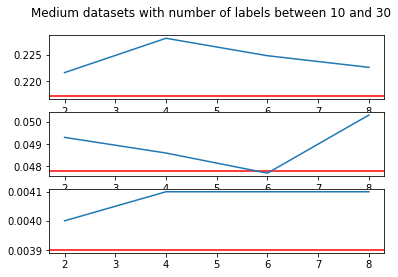

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Medium datasets with number of labels between 10 and 30')
x = [2, 4, 6, 8]
y_yeast = [0.2216, 0.2281, 0.2248, 0.2226]
y_birds = [0.0493, 0.0486, 0.0477, 0.0503]
y_genbase = [0.0040, 0.0041, 0.0041, 0.0041]
ax1.axhline(y=0.2171, color='r', linestyle='-')
ax1.plot(x, y_yeast)
ax2.axhline(y=0.0478, color='r', linestyle='-')
ax2.plot(x, y_birds)
ax3.axhline(y=0.0039, color='r', linestyle='-')
ax3.plot(x, y_genbase)

medical
Ave Standard Classification Accuracy: 0.0229
Ave Super Classification with 2 clusters: 0.0234
Ave Super Classification with 4 clusters: 0.0244
Ave Super Classification with 6 clusters: 0.0241
Ave Super Classification with 8 clusters: 0.0240
Ave Super Classification with 10 clusters: 0.0239

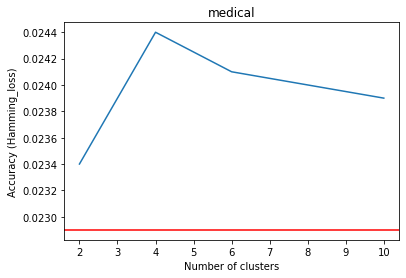

In [105]:
plt.xlabel('Number of clusters') 
plt.ylabel('Accuracy (Hamming_loss)') 
plt.axhline(y=0.0229, color='r', linestyle='-')
x_values = [2, 4, 6, 8, 10]
y_values = [0.0234, 0.0244, 0.0241, 0.0240, 0.0239]
plt.plot(x_values, y_values) 
plt.title('medical')
plt.show()

enron
Ave Standard Classification Accuracy: 0.0657
Ave Super Classification with 2 clusters: 0.0653
Ave Super Classification with 4 clusters: 0.0664
Ave Super Classification with 6 clusters: 0.0672
Ave Super Classification with 8 clusters: 0.0664
Ave Super Classification with 10 clusters: 0.0651

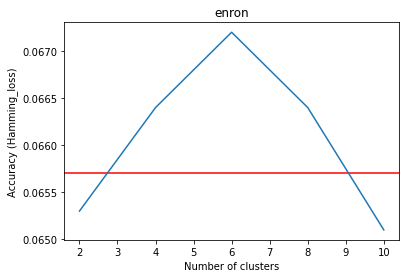

In [106]:
plt.xlabel('Number of clusters') 
plt.ylabel('Accuracy (Hamming_loss)') 
plt.axhline(y=0.0657, color='r', linestyle='-')
x_values = [2, 4, 6, 8, 10]
y_values = [0.0653, 0.0664, 0.0672, 0.0664, 0.0651]
plt.plot(x_values, y_values) 
plt.title('enron')
plt.show()

bibtex
Ave Standard Classification Accuracy: 0.0168
Ave Super Classification with 2 clusters: 0.0168
Ave Super Classification with 4 clusters: 0.0171
Ave Super Classification with 6 clusters: 0.0170
Ave Super Classification with 8 clusters: 0.0176
Ave Super Classification with 10 clusters: 0.0173

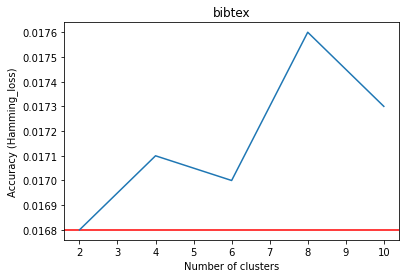

In [107]:
plt.xlabel('Number of clusters') 
plt.ylabel('Accuracy (Hamming_loss)') 
plt.axhline(y=0.0168, color='r', linestyle='-')
x_values = [2, 4, 6, 8, 10]
y_values = [0.0168, 0.0171, 0.0170, 0.0176, 0.0173]
plt.plot(x_values, y_values) 
plt.title('bibtex')
plt.show()

Corel5k
Ave Standard Classification Accuracy: 0.0121
Ave Super Classification with 2 clusters: 0.0122
Ave Super Classification with 4 clusters: 0.0122
Ave Super Classification with 6 clusters: 0.0121
Ave Super Classification with 8 clusters: 0.0120
Ave Super Classification with 10 clusters: 0.0122

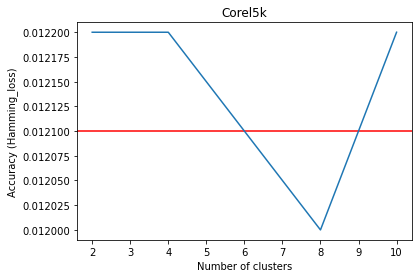

In [108]:
plt.xlabel('Number of clusters') 
plt.ylabel('Accuracy (Hamming_loss)') 
plt.axhline(y=0.0121, color='r', linestyle='-')
x_values = [2, 4, 6, 8, 10]
y_values = [0.0122, 0.0122, 0.0121, 0.0120, 0.0122]
plt.plot(x_values, y_values) 
plt.title('Corel5k')
plt.show()

Full feature standard classfification acc vs Super classification PSO selected acc

In [54]:
# Main entry

data = read_arff('datasets/' + datasets[6] + '.arff')

# y = data.iloc[:, locations[6]:]
# X = data.iloc[:, :locations[6]]
# n_features = len(list(X))
# X = X.to_numpy()
# y = y.to_numpy()

X, y, feature_names, label_names = load_dataset(datasets_large[0], 'undivided')
X = pd.DataFrame.sparse.from_spmatrix(X).to_numpy()
y = pd.DataFrame.sparse.from_spmatrix(y).to_numpy()

n_splits = 5
k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state = 42)

full_hams = []
sel_hams = []
PSO_durations = []
f_ratios = []
to_print = ''
fold_count = 0

for train_idx, test_idx in k_fold.split(X, y):
    print('Fold ', fold_count)
    fold_count += 1

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

        # get full acc
    scaler = StandardScaler()
#     scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    
    
    clf = MLkNN(k=3)
    clf.fit(X_train_scaled, y_train)
    y_test_pred = clf.predict(X_test_scaled)
    full_ham = hamming_loss(y_test, y_test_pred)
    full_hams.append(full_ham)
    
    
    #  perform FS
    start_PSO = time.time_ns()    # marking start time of PSO 
#        problem = FS_ML(minimize=True, X=X_train, y=y_train)
    problem = FS_ML_super(minimize=True, X=X_train, y=y_train)

    # parameter for PSO
    pop_size = 3
    n_iterations = 5
    swarm = Swarm(n_particles=pop_size, length=n_features, pos_max=1.0, pos_min=0,
                       vel_max=0.2, vel_min=-0.2, problem=problem, n_iterations=n_iterations)    
    best_sol, best_fit = swarm.iterate()
    end_PSO = time.time_ns()      # marking ending time of PSO
    duration_PSO = round((end_PSO - start_PSO)/1000000000, 2)
    PSO_durations.append(duration_PSO)
    
    
    # process the final solution
    sel_fea = np.where(best_sol > problem.threshold)[0]
    clf.fit(X_train[:, sel_fea], y_train)
    y_test_pred = clf.predict(X_test[:, sel_fea])
    fold_ham = hamming_loss(y_true=y_test, y_pred=y_test_pred)
    sel_hams.append(fold_ham)
    f_ratios.append(len(sel_fea)/n_features)

    # to write the results
    to_print += '--------------Fold %d----------------\n' % fold_count
    to_print += 'Full feature hamming loss: %.4f\n' % full_ham
    to_print += 'Fold selected hamming loss: %.4f\n' % fold_ham
    to_print += 'Time of PSO: %.4f\n' % duration_PSO
    to_print += 'Selection ratio: %.2f\n' % (len(sel_fea)/n_features)
    to_print += 'Selected features: %s\n' % (', '.join([str(ele) for ele in sel_fea]))

to_print += '--------------Average----------------\n'
to_print += 'Ave Full Accuracy: %.4f\n' % np.average(full_hams)
to_print += 'Ave Selection Accuracy: %.4f\n' % np.average(sel_hams)
to_print += 'Ave time of PSO: %.4f\n' % np.average(PSO_durations)
to_print += 'Ave Feature Ratio: %.2f\n' % np.average(f_ratios)

f = open('records/record_' + datasets[6] + '_super_PSO.txt', 'w')
f.write(to_print)
f.close()

Fold  0
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10470910472386
Iterate  2  gbest value is  0.10166311485847494
Iterate  3  gbest value is  0.10166311485847494
Iterate  4  gbest value is  0.10166311485847494
Fold  1
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.1047325435269018
Iterate  2  gbest value is  0.10452233554469884
Iterate  3  gbest value is  0.10154203061304254
Iterate  4  gbest value is  0.10154203061304254
Fold  2
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.09831199379037225
Iterate  2  gbest value is  0.09831199379037225
Iterate  3  gbest value is  0.09804015334541763
Iterate  4  gbest value is  0.09804015334541763
Fold  3
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.09906150874510802
Iterate  2  gbest value is  0.09849433193971643
Iterate  3  gbest value is  0.09849433193971643
Iterate  4  gbest value is  0.09849433193971643
Fold  4
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.104098

Standard PSO FS time cost vs Super PSO FS time cost

In [55]:
# Main entry

data = read_arff('datasets/' + datasets[6] + '.arff')

y = data.iloc[:, locations[6]:]
X = data.iloc[:, :locations[6]]

n_features = len(list(X))
X = X.to_numpy()
y = y.to_numpy()

n_splits = 5
k_fold = IterativeStratification(n_splits=n_splits, order=1, random_state = 42)

full_hams = []
sel_hams = []
PSO_durations = []
f_ratios = []
to_print = ''
fold_count = 0

for train_idx, test_idx in k_fold.split(X, y):
    print('Fold ', fold_count)
    fold_count += 1

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # get full acc
    scaler = StandardScaler()
#     scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    clf = MLkNN(k=3)
    clf.fit(X_train_scaled, y_train)
    y_test_pred = clf.predict(X_test_scaled)
    full_ham = hamming_loss(y_test, y_test_pred)
    full_hams.append(full_ham)
    
    
    #  perform FS
    start_PSO = time.time_ns()    # marking start time of PSO 
    problem = FS_ML(minimize=True, X=X_train, y=y_train)
#     problem = FS_ML_super(minimize=True, X=X_train, y=y_train)

    # parameter for PSO
    pop_size = 3
    n_iterations = 5
    swarm = Swarm(n_particles=pop_size, length=n_features, pos_max=1.0, pos_min=0,
                       vel_max=0.2, vel_min=-0.2, problem=problem, n_iterations=n_iterations)    
    best_sol, best_fit = swarm.iterate()
    end_PSO = time.time_ns()      # marking ending time of PSO
    duration_PSO = round((end_PSO - start_PSO)/1000000000, 2)
    PSO_durations.append(duration_PSO)
    
    # process the final solution
    sel_fea = np.where(best_sol > problem.threshold)[0]
    clf.fit(X_train[:, sel_fea], y_train)
    y_test_pred = clf.predict(X_test[:, sel_fea])
    fold_ham = hamming_loss(y_true=y_test, y_pred=y_test_pred)
    sel_hams.append(fold_ham)
    f_ratios.append(len(sel_fea)/n_features)

    # to write the results
    to_print += '--------------Fold %d----------------\n' % fold_count
    to_print += 'Full feature hamming loss: %.4f\n' % full_ham
    to_print += 'Fold selected hamming loss: %.4f\n' % fold_ham
    to_print += 'Time of PSO: %.4f\n' % duration_PSO
    to_print += 'Selection ratio: %.2f\n' % (len(sel_fea)/n_features)
    to_print += 'Selected features: %s\n' % (', '.join([str(ele) for ele in sel_fea]))

to_print += '--------------Average----------------\n'
to_print += 'Ave Full Accuracy: %.4f\n' % np.average(full_hams)
to_print += 'Ave Selection Accuracy: %.4f\n' % np.average(sel_hams)
to_print += 'Ave time of PSO: %.4f\n' % np.average(PSO_durations)
to_print += 'Ave Feature Ratio: %.2f\n' % np.average(f_ratios)

f = open('records/record_' + datasets[6] + '_standardPSO.txt', 'w')
f.write(to_print)
f.close()

Fold  0
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10053697819836607
Iterate  2  gbest value is  0.10053697819836607
Iterate  3  gbest value is  0.10053697819836607
Iterate  4  gbest value is  0.10053697819836607
Fold  1
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10302277941047297
Iterate  2  gbest value is  0.10302277941047297
Iterate  3  gbest value is  0.10302277941047297
Iterate  4  gbest value is  0.10138353021981936
Fold  2
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.0962167647246712
Iterate  2  gbest value is  0.0962167647246712
Iterate  3  gbest value is  0.0962167647246712
Iterate  4  gbest value is  0.0962167647246712
Fold  3
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.10309103367896781
Iterate  2  gbest value is  0.10309103367896781
Iterate  3  gbest value is  0.10309103367896781
Iterate  4  gbest value is  0.09910224523650166
Fold  4
Iterate  0  gbest value is  inf
Iterate  1  gbest value is  0.102335